## 네이버 영화 리뷰 감성 분석

### 준비 사항

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)  

Mounted at /gdrive


In [2]:
#BERT와 GPT에서 쓰이는 트랜스 포머 모델과는 다름(transformer 모델 / transformers 패키지 툴 : 뒤에 s로 구분)
#Hugging Face의 api and tools to easily download and train state of art pretrained model
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 107.4 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

### 데이터 로드

- 박은정님의 네이버 영화리뷰 감정분석 데이터를 GitHub에서 다운로드

In [4]:
#네이버 영화 리뷰 감정 분석 데이터 다운로드
!git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 23.45 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


- 아래와 같이 nsmc 디렉토리에 있는 ratings_train.txt와 ratings_test.txt를 사용함

In [5]:
#디렉토리의 파일 목록
!ls nsmc -la

total 38644
drwxr-xr-x 5 root root     4096 Jan 17 02:02 .
drwxr-xr-x 1 root root     4096 Jan 17 02:02 ..
drwxr-xr-x 2 root root     4096 Jan 17 02:02 code
drwxr-xr-x 8 root root     4096 Jan 17 02:02 .git
-rw-r--r-- 1 root root  4893335 Jan 17 02:02 ratings_test.txt
-rw-r--r-- 1 root root 14628807 Jan 17 02:02 ratings_train.txt
-rw-r--r-- 1 root root 19515078 Jan 17 02:02 ratings.txt
drwxr-xr-x 2 root root   471040 Jan 17 02:02 raw
-rw-r--r-- 1 root root     2596 Jan 17 02:02 README.md
-rw-r--r-- 1 root root    36746 Jan 17 02:02 synopses.json


In [6]:
%pwd

'/content'

- pandas로 훈련 셋과 테스트 셋 데이터 로드
  * 훈련 셋 150,000개와 테스트 셋 50,000개의 데이터가 존재

In [7]:
train = pd.read_csv("nsmc/ratings_train.txt", sep='\t')
test = pd.read_csv("nsmc/ratings_test.txt", sep='\t')

print(train.shape)
print(test.shape)

(150000, 3)
(50000, 3)


- 훈련 셋의 앞부분 출력
  * id는 회원정보, document는 리뷰 문장, \
label이 0이면 부정, 1이면 긍정으로 분류, \
id는 사용하지 않기 때문에 document와 label만 추출

In [8]:
train.head(10)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


### 데이터 전처리

#### 훈련 데이터셋

- 리뷰 문장 추출

In [9]:
sentences = train['document']
sentences[:10]

0                                  아 더빙.. 진짜 짜증나네요 목소리
1                    흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                        교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
5        막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.
6                                원작의 긴장감을 제대로 살려내지못했다.
7    별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...
8                               액션이 없는데도 재미 있는 몇안되는 영화
9        왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?
Name: document, dtype: object

- BERT의 입력 형식에 맞게 변환

In [10]:
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

['[CLS] 아 더빙.. 진짜 짜증나네요 목소리 [SEP]',
 '[CLS] 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나 [SEP]',
 '[CLS] 너무재밓었다그래서보는것을추천한다 [SEP]',
 '[CLS] 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정 [SEP]',
 '[CLS] 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다 [SEP]',
 '[CLS] 막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움. [SEP]',
 '[CLS] 원작의 긴장감을 제대로 살려내지못했다. [SEP]',
 '[CLS] 별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네 [SEP]',
 '[CLS] 액션이 없는데도 재미 있는 몇안되는 영화 [SEP]',
 '[CLS] 왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나? [SEP]']

- BERT의 입력은 다음 그림과 같은 형식
  * Classification을 뜻하는 [CLS]심볼이 맨 앞에 삽입됨
  * 파인튜닝시 출력에서 이위치의 값을 사용하여 분류함
  * [SEP]은 Seperation, 두 문장을 구분하는 역할
  * 이 예제에서는 문장이 하나이므로 [SEP]도 하나만 넣음

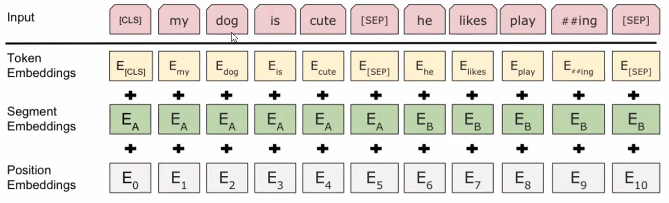

- 라벨 추출

In [11]:
labels = train['label'].values
labels

array([0, 1, 0, ..., 0, 1, 0])

- BERT의 토크나이저로 문장을 토큰으로 분리

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print(sentences[0])
print(tokenized_texts[0])

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

[CLS] 아 더빙.. 진짜 짜증나네요 목소리 [SEP]
['[CLS]', '아', '더', '##빙', '.', '.', '진', '##짜', '짜', '##증', '##나', '##네', '##요', '목', '##소', '##리', '[SEP]']


BERT는 형태소 분석으로 토큰을 분리하지 않음, WordPiece라는 통계적인 방식을 사용 \
한 단어 내에서 자주 나오는 글자들을 붙여서 하나의 토큰으로 만듦 \
이렇게 하면 언어에 상관없이 토큰을 생성할 수 있다는 장점이 있음 \
또한 신조어 같이 사전에 없는 단어를 처리하기도 좋음 \
위의 결과에서 ## 기호는 앞 토큰과 이어진다는 표시 \
토크나이저는 여러 언어의 데이터를 기반으로 만든 'bert-base-multilingual-cased'를 사용, 그래서 한글도 처리가 가능


- input_ids 설정

In [13]:
#입력 토큰의 초대 시퀀스 길이
MAX_LEN = 128

#토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

#문장을 MAX_LEN 길이에 맞게 자록, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')
input_ids[0]

array([   101,   9519,   9074, 119005,    119,    119,   9708, 119235,
         9715, 119230,  16439,  77884,  48549,   9284,  22333,  12692,
          102,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

보통 딥러닝 모델에는 토큰 자체를 입력으로 넣을 수 없음 \
임베딩 레이어에는 토큰을 숫자로 된 인덱스로 변환하여 사용 \
BERT의 토크나이저는 {단어토큰:인덱스}로 구성된 단어사전을 가지고 있음 \
이를 참조하여 토큰을 인덱스로 바꿔줌

In [14]:
#[참고] 불린 인덱싱
list = [0,1,1,3.1]
for i in list:
  print(float(i>0), end=' ')   #true: 1, false: 0으로 출력

0.0 1.0 1.0 1.0 

- attention_masks 설정

In [15]:
#어텐션 마스크 초기화
attention_masks=[]

#어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
#패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


- 훈련 데이터셋과 검증 데이터셋으로 분리

In [16]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                                                    random_state=2018,
                                                                                    test_size=0.1)

- 어텐션 마스크를 훈련 데이터셋과 검증 데이터셋으로 분리

In [17]:
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                                       random_state=2018,
                                                       test_size=0.1)

- 데이터를 파이토치의 텐서로 변환

In [18]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

print(train_inputs[0])
print(train_labels[0])
print(train_masks[0])
print(validation_inputs[0])
print(validation_labels[0])
print(validation_masks[0])

tensor([   101,   9711,  11489,   9364,  41850,   9004,  32537,   9491,  35506,
         17360,  48549,    119,    119,   9477,  26444,  12692,   9665,  21789,
         11287,   9708, 119235,   9659,  22458, 119136,  12965,  48549,    119,
           119,   9532,  22879,   9685,  16985,  14523,  48549,    119,    119,
          9596, 118728,    119,    119,   9178, 106065, 118916,    119,    119,
          8903,  11664,  11513,   9960,  14423,  25503, 118671,  48549,    119,
           119,  21890,   9546,  37819,  22879,   9356,  14867,   9715, 119230,
        118716,  48345,    119,   9663,  23321,  10954,   9638,  35506, 106320,
         10739,  20173,   9359,  19105,  11102,  42428,  17196,  48549,    119,
           119,    100,    117,   9947,  12945,   9532,  25503,   8932,  14423,
         35506, 119050,  11903,  14867,  10003,  14863,  33188,  48345,    119,
           102,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0, 

- 데이터 로더 만들기

In [19]:
#배치 사이즈
batch_size=32

#파이토치의 DAtaLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
#학습시 배치 사이즈만큼 데이터를 가져옴
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

#### 테스트 데이터셋

- 리뷰 문장 추출

In [20]:
sentences = test['document']
sentences[:10]

0                                                  굳 ㅋ
1                                 GDNTOPCLASSINTHECLUB
2               뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아
3                     지루하지는 않은데 완전 막장임... 돈주고 보기에는....
4    3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??
5                                   음악이 주가 된, 최고의 음악영화
6                                              진정한 쓰레기
7             마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다
8    갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한c...
9       이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But, 모든 사람이 그렇지는 않네..
Name: document, dtype: object

- BERT의 입력 형식에 맞게 변환

In [21]:
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

['[CLS] 굳 ㅋ [SEP]',
 '[CLS] GDNTOPCLASSINTHECLUB [SEP]',
 '[CLS] 뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아 [SEP]',
 '[CLS] 지루하지는 않은데 완전 막장임... 돈주고 보기에는.... [SEP]',
 '[CLS] 3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠?? [SEP]',
 '[CLS] 음악이 주가 된, 최고의 음악영화 [SEP]',
 '[CLS] 진정한 쓰레기 [SEP]',
 '[CLS] 마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다 [SEP]',
 '[CLS] 갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한cg남무 아 그립다 동사서독같은 영화가 이건 3류아류작이다 [SEP]',
 '[CLS] 이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But, 모든 사람이 그렇지는 않네.. [SEP]']

- 라벨 추출

In [22]:
labels = test['label'].values
labels

array([1, 0, 0, ..., 0, 0, 0])

- BERT의 토크나이저로 문장을 토큰으로 분리

In [23]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print(sentences[0])
print(tokenized_texts[0])

[CLS] 굳 ㅋ [SEP]
['[CLS]', '굳', '[UNK]', '[SEP]']


- input_ids 설정

In [24]:
#입력 토큰의 초대 시퀀스 길이
MAX_LEN = 128

#토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

#문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')
input_ids[0]

array([ 101, 8911,  100,  102,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

- attention_masks 설정

In [25]:
#어텐션 마스크 초기화
attention_masks = []

#어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
#패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


- 데이터를 파이토치의 텐서로 변환

In [26]:
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

print(test_inputs[0])
print(test_labels[0])
print(test_masks[0])

tensor([ 101, 8911,  100,  102,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
tensor(1)
tensor([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

- 데이터 로더 만들기

In [27]:
#배치 사이즈
batch_size=32

#파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
#학습시 배치 사이즈만큼 데이터를 가져옴
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

### 모델 생성

- 디바이스 이름 검사

In [28]:
#GPU 디바이스 이름 구함
device_name = tf.test.gpu_device_name()

#GPU 디바이스 이름 검사
if device_name == '/device:GPU:0':
  print('Found GPU at: {}'.format(device_name))
else:
  raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


- 디바이스 설정

In [29]:
if torch.cuda.is_available():
  device=torch.device("cuda")
  print('There are %d GPU(s) available.' % torch.cuda.device_count())
  print('We will use the GPU: ', torch.cuda.get_device_name(0))
else:
  device=torch.device("cpu")
  print('No GPU available, using te CPU instead.')

There are 1 GPU(s) available.


- 분류를 위한 BERT 모델 생성

In [30]:
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
model.cuda()

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

- 옵티마이저 & 스케줄러 생성

In [31]:
#옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr=2e-5,    #학습률
                  eps=1e-8    #0으로 나누는 것을 방지하기 위한 epsilon 값
                  )

#에폭수
epochs=4

#총 훈련 스텝: 배치 반복 횟수*에폭
total_steps = len(train_dataloader)*epochs

#처음에 학습률을 조금씩 변화시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0, #The number of steps for the warmup phase.#warmup=0이면 안 쓰기로 함
                                            num_training_steps=total_steps)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### 모델 학습

In [32]:
#정확도 계산 함수
def flat_accuracy(preds, labels):
  pred_flat=np.argmax(preds, axis=1).flatten()
  labels_flat=labels.flatten()

  return np.sum(pred_flat == labels_flat)/len(labels_flat)

#시간 표시 함수
def format_time(elapsed):

  #반올림
  elapsed_rounded=int(round((elapsed)))
  
  #hh:mm:ss으로 형태 변경
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [33]:
#재현을 위해 랜덤시드 고정
seed_val=42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

#그래디언트 초기화
model.zero_grad()

#에폭만큼 반복
for epoch_i in range(0, epochs):
  # ==========================================
  #                 Training
  # ==========================================

  print("")
  print("======== Epoch {:} / {:} ========".format(epoch_i+1, epochs))
  print("Training...")

  #시작 시간 설정
  t0 = time.time()

  #로스 초기화
  total_loss = 0

  #훈련모드로 변경
  model.train()

  #데이터로더에서 배치만큼 반복하여 가져옴
  for step, batch in enumerate(train_dataloader):
    #경과 정보 표시
    if step%500 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)
      print(" Batch {:>5,} of {:>5,}.   Elapsed: {:}.".format(step, len(train_dataloader), elapsed))
      #{:>5} 전체 5칸을 차지하며 공백을 앞에 붙임

    #배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    #배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch

    #Forward 수행
    outputs = model(b_input_ids,
                   token_type_ids=None,
                   attention_mask=b_input_mask,
                   labels=b_labels)

    #로스 구함
    loss = outputs[0]

    #총 로스 계산
    total_loss += loss.item()

    #BAckward 수행으로 그래디언트 계산
    loss.backward()

    #그래디언트 클리핑: 학습 중 기울기 소실 또는 Exploading이 발생하는 것을 방지
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)   #max_norm

    #그래디언트를 통해 가중치 파라미터 업데이트
    optimizer.step()

    #스케줄러로 학습률 감소
    scheduler.step()

    #그래디언트 초기화
    model.zero_grad()

  #평균 로스 계산
  avg_train_loss = total_loss / len(train_dataloader)

  print("")
  print(" Average training loss: {0:.2f}".format(avg_train_loss))
  print(" Training epoch took: {:}".format(format_time(time.time()-t0)))

  # ==========================================
  #                 validation
  # ==========================================

  print("")
  print("Running Validation...")

  #시작 시간 설정
  t0 = time.time()

  #평가모드로 변경
  model.eval()

  #변수 초기화
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  #데이터 로더에서 배치만큼 반복하여 가져옴
  for batch in validation_dataloader:

    #배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    #배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch

    #그래디언트 계산 안함
    with torch.no_grad():
      #Forward 수행
      outputs = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask)
      
    #로스 구함
    logits = outputs[0]

    #CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    #출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  
  print("   Accuracy: {0: .2f}".format(eval_accuracy/nb_eval_steps))
  print("   Validation took: {:}".format(format_time(time.time()-t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
 Batch   500 of 4,219.   Elapsed: 0:05:27.
 Batch 1,000 of 4,219.   Elapsed: 0:10:56.
 Batch 1,500 of 4,219.   Elapsed: 0:16:24.
 Batch 2,000 of 4,219.   Elapsed: 0:21:53.
 Batch 2,500 of 4,219.   Elapsed: 0:27:21.
 Batch 3,000 of 4,219.   Elapsed: 0:32:50.
 Batch 3,500 of 4,219.   Elapsed: 0:38:18.
 Batch 4,000 of 4,219.   Elapsed: 0:43:46.

 Average training loss: 0.38
 Training epoch took: 0:46:10

Running Validation...
   Accuracy:  0.86
   Validation took: 0:01:43

======== Epoch 2 / 4 ========
Training...
 Batch   500 of 4,219.   Elapsed: 0:05:28.
 Batch 1,000 of 4,219.   Elapsed: 0:10:57.
 Batch 1,500 of 4,219.   Elapsed: 0:16:25.
 Batch 2,000 of 4,219.   Elapsed: 0:21:54.
 Batch 2,500 of 4,219.   Elapsed: 0:27:22.
 Batch 3,000 of 4,219.   Elapsed: 0:32:51.
 Batch 3,500 of 4,219.   Elapsed: 0:38:19.
 Batch 4,000 of 4,219.   Elapsed: 0:43:47.

 Average training loss: 0.28
 Training epoch took: 0:46:10

Running Validation...
   Accuracy: 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> 에폭마다 훈련 데이터셋과 검증 데이터셋을 반복하여 학습을 수행

### 평가

테스트 셋의 정확도가 87%, <BERT 보기> 블로그에서는 같은 데이터로 88.7%를 달성 \
블로그에서는 한글 코퍼스로 사전 훈련을 하여 새로운 모델을 만들었고, \
반면에 우리는 BERT의 기본 모델은 bert-base-multilingual-cased를 사용했기 때문에 성능이 더 낮은 것 같다.

In [ ]:
PATH = '/content/drive/MyDrive/nlpbook/model.pt'
torch.save(model.PATH)

In [ ]:
PATH = '/content/drive/MyDrive/nlpbook/model.pt'
model = torch.load(PATH)
model.eval()

### 새로운 문장 테스트

- 입력 데이터 변환 함수 생성

In [34]:
#입력 데이터 변환
def convert_input_data(sentences):

  #BERT의 토크나이저로 문장을 토큰으로 분리
  tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

  #입력 토큰의 최대 시퀀스 길이
  MAX_LEN = 128

  #토큰을 숫자 인덱스로 변환
  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

  #문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')

  #어텐션 마스크 초기화
  attention_masks = []

  #어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
  #패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
  for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

  #데이터를 파이토치의 텐서로 변환
  inputs = torch.tensor(input_ids)
  masks = torch.tensor(attention_masks)

  return inputs, masks

- 문장 테스트 함수 생성

In [35]:
#문장 테스트
def test_sentences(sentences):

  #평가모드로 변경
  model.eval()

  #문장을 입력 데이터로 변환
  inputs, masks = convert_input_data(sentences)

  #데이터를 GPU에 넣음
  b_input_ids = input.to(device)
  b_input_mask = input.to(device)

  #그래디언트 계산 안함
  with torch.no_grad():
    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask)
    
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  pred = "긍정 (positive)" if np.argmax(logits) == 1 else "부정 (negative)"
  return logits, pred

In [36]:
sentence = ["연기는 별로지만 재미 하나는 끝내줌!"]
test_sentences(sentence)

AttributeError: ignored

In [ ]:
sentence = ["주연배우가 아깝다. 총체적 난국..."]
test_sentences(sentence)